In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
g = tf.Graph()
with g.as_default():
    x = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w * x + b
    init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session(graph=g) as sess:
    sess.run(init)
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f' % (t, sess.run(z, feed_dict={x: t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [4]:
import numpy as np

g = tf.Graph()

with g.as_default():
    x = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')

    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')

    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.compat.v1.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n', sess.run(x2, feed_dict={x: x_array}))
    print('Column Sums:\n', sess.run(xsum, feed_dict={x: x_array}))
    print('Column Means:\n', sess.run(xmean, feed_dict={x: x_array}))


input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


In [5]:
X_train = np.arange(10).reshape(10, 1)
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [6]:
class TfLinreg:

    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()

        with self.g.as_default():
            tf.compat.v1.set_random_seed(random_seed)

            self.build()

            self.init_op = tf.compat.v1.global_variables_initializer()

    def build(self):
        self.X = tf.compat.v1.placeholder(dtype=tf.float32,
                                          shape=(None, self.x_dim),
                                          name='x_input')
        self.y = tf.compat.v1.placeholder(dtype=tf.float32,
                                          shape=(None),
                                          name='y_input')

        print(self.X)
        print(self.y)

        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')

        print(w)
        print(b)

        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        print(self.z_net)

        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')

        optimizer = tf.compat.v1.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate,
            name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [7]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(None, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32>
<tf.Variable 'bias:0' shape=(1,) dtype=float32>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [8]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    sess.run(model.init_op)

    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                           feed_dict={model.X: X_train, model.y: y_train})
        training_costs.append(cost)

    return training_costs

In [9]:
sess = tf.compat.v1.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

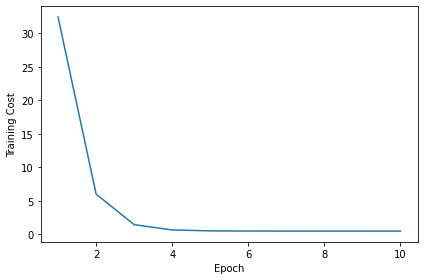

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.tight_layout()
plt.show()

In [11]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X: X_test})
    return y_pred

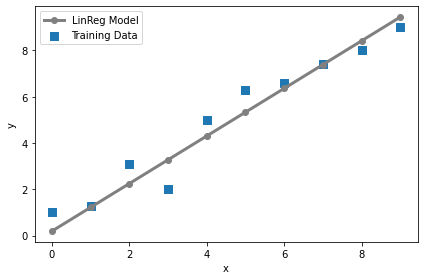

In [12]:
plt.scatter(X_train, y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]),
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
import os
import struct
import numpy as np


def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb')  as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

In [14]:
X_train, y_train = load_mnist('mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [15]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val
del X_train, X_test
print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [16]:
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.compat.v1.set_random_seed(random_seed)
    tf_x = tf.compat.v1.placeholder(dtype=tf.float32,
                                    shape=(None, n_features),
                                    name='tf_x')
    tf_y = tf.compat.v1.placeholder(dtype=tf.int32,
                                    shape=None,
                                    name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    h1 = tf.compat.v1.layers.dense(inputs=tf_x,
                                   units=50,
                                   activation=tf.tanh,
                                   name='layer1')
    h2 = tf.compat.v1.layers.dense(inputs=h1,
                                   units=50,
                                   activation=tf.tanh,
                                   name='layer2')
    logits = tf.compat.v1.layers.dense(inputs=h2,
                                       units=10,
                                       activation=None,
                                       name='layer3')

    predictions = {
        'classes': tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }


c:\users\1023d\.virtualenvs\pythonmachinelearning-qwvwlql2\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\1023d\.virtualenvs\pythonmachinelearning-qwvwlql2\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [17]:
with g.as_default():
    cost = tf.compat.v1.losses.softmax_cross_entropy(onehot_labels=y_onehot,
                                                     logits=logits)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.compat.v1.global_variables_initializer()

In [18]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)

    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)

    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i + batch_size, :], y_copy[i:i + batch_size])

In [19]:
sess = tf.compat.v1.Session(graph=g)
sess.run(init_op)

training_costs = []
for epoch in range(50):
    training_loss = []
    batch_generator = create_batch_generator(X_train_centered, y_train,
                                             batch_size=64)

    for batch_X, batch_y in batch_generator:
        feed = {tf_x: batch_X, tf_y: batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)

    print(' -- Epoch %2d  '
          'Avg. Training Loss: %.4f' % (epoch + 1, np.mean(training_costs)))


 -- Epoch  1  Avg. Training Loss: 1.5841
 -- Epoch  2  Avg. Training Loss: 1.2739
 -- Epoch  3  Avg. Training Loss: 1.1002
 -- Epoch  4  Avg. Training Loss: 0.9846
 -- Epoch  5  Avg. Training Loss: 0.9005
 -- Epoch  6  Avg. Training Loss: 0.8360
 -- Epoch  7  Avg. Training Loss: 0.7845
 -- Epoch  8  Avg. Training Loss: 0.7422
 -- Epoch  9  Avg. Training Loss: 0.7067
 -- Epoch 10  Avg. Training Loss: 0.6764
 -- Epoch 11  Avg. Training Loss: 0.6501
 -- Epoch 12  Avg. Training Loss: 0.6271
 -- Epoch 13  Avg. Training Loss: 0.6066
 -- Epoch 14  Avg. Training Loss: 0.5884
 -- Epoch 15  Avg. Training Loss: 0.5719
 -- Epoch 16  Avg. Training Loss: 0.5569
 -- Epoch 17  Avg. Training Loss: 0.5433
 -- Epoch 18  Avg. Training Loss: 0.5308
 -- Epoch 19  Avg. Training Loss: 0.5192
 -- Epoch 20  Avg. Training Loss: 0.5085
 -- Epoch 21  Avg. Training Loss: 0.4985
 -- Epoch 22  Avg. Training Loss: 0.4892
 -- Epoch 23  Avg. Training Loss: 0.4805
 -- Epoch 24  Avg. Training Loss: 0.4724
 -- Epoch 25  Av

In [20]:
feed = {tf_x: X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)

print('Test Accuracy: %.2f%%' % (100 * np.sum(y_pred == y_test) / y_test.shape[0]))


Test Accuracy: 93.67%


In [21]:
np.random.seed(123)
tf.compat.v1.set_random_seed(123)

In [22]:
y_train_onehot = tf.keras.utils.to_categorical(y_train)
print('First 3 labels: ', y_train[:3])
print('\nFirst 3 labels (one-hot):\n', y_train_onehot[:3])


First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [23]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units=50,
                                input_dim=X_train_centered.shape[1],
                                kernel_initializer='glorot_uniform',
                                bias_initializer='zeros',
                                activation='tanh'))

model.add(tf.keras.layers.Dense(units=50,
                                input_dim=50,
                                kernel_initializer='glorot_uniform',
                                bias_initializer='zeros',
                                activation='tanh'))

model.add(tf.keras.layers.Dense(units=y_train_onehot.shape[1],
                                input_dim=50,
                                kernel_initializer='glorot_uniform',
                                bias_initializer='zeros',
                                activation='softmax'))

sgd_optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')

c:\users\1023d\.virtualenvs\pythonmachinelearning-qwvwlql2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
history = model.fit(X_train_centered,
                    y_train_onehot,
                    batch_size=64,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.7320 - val_loss: 0.3652

In [32]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print('First 3 predictions: ', y_train_pred[:3])
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

c:\users\1023d\.virtualenvs\pythonmachinelearning-qwvwlql2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


First 3 predictions:  [5 0 4]
Training accuracy: 98.88%
Test accuracy: 96.26%


In [33]:
import numpy as np

X = np.array([1, 1.4, 2.5])
w = np.array([0.4, 0.3, 0.5])


def net_init(X, w):
    return np.dot(X, w)


def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))


def logistic_activation(X, w):
    z = net_init(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w))

P(y=1|x) = 0.888


In [36]:
W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

A = np.array([[1, 0.1, 0.4, 0.6]])

Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input:\n', Z)
print('Output Units:\n', y_probas)

Net Input:
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [37]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class)

Predicted class label: 0


In [38]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)
np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0